- Name: Daniel Lew
- PID: A12170444
- COGS118C - Assignment 1

# This notebook has [30 + 3 bonus] points in total 
##### The number of points for each question is denoted by []. Make sure you've answered all the questions and that the point total add up.

---
# Lab 1 - Time Series, Sampling, and Epoched Analysis (ERPs)
In this lab, we will cover the first stages of signal processing: sampling data. This includes digitization and sampling theorem. We will generate and plot some signals. 

Then, we'll perform our first kind of neural signal analysis: event-related potentials.

Key concepts:
- visualizing time-series
- digitization/quantization
- sampling
- (more) indexing arrays
- epoching
- event-related potentials (ERPs): noise and averaging

# Analog signals
Real world signals are continuous in time and amplitude (up to quantum-level limits, anyway). These are referred to as **"analog"** signals (Google it). Soundwaves that we produce when we speak or when we play a violin, for example, are analog signals. 

Equivalently, there are "analog devices" that produce, receive, and/or operate on analog signals. These often involve "analog" circuits.

# [1] Q1:
Give 3 examples of analog devices
1. Old Radios 
2. Megaphone
3. Tape Recorders

# Digital signals
People used to analyze signals using analog circuits. This is pretty hardcore, and requires extensive hands-on knowledge about circuitry. Once you want to analyze the signal on a "digital" computer, however, you have to "digitize" the signal. This requires an **"analog-to-digital converter"** or ADC for short. 

---
A tangent (without delving too much into how a computer works): all modern computers operate with binary transistors, which use a combination of "bits" to represent all other types of information. In the analog world, there are an infinite number of number between 0 and 1, so there is a limit to how accurately we can represent small decimals (or really big numbers). Python uses [floating point](https://0.30000000000000004.com/). Everything you see on your screen, at the lowest level, is converted into a numerical **binary** representation, even strings (see [ASCII](https://www.cs.cmu.edu/~pattis/15-1XX/common/handouts/ascii.html) table, for example).

---
Anyway, to digitize an analog signal, you have to discretely sample, both in value (voltage, brightness, etc) and in time. The former is usually called **digitization or quantization**, while **sampling** usually refers to the latter. It's like drawing a grid over your continuous signals and interpolating its values only at where the grid crosses.
![sampling](img/WvD_fig1_6.png)

# Let's get into it
Without further ado: let's load up some EEG signals and explore. But first, make the necessary python module imports.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import io # this submodule let's us load the signal we want
%matplotlib inline

dict_keys(['__header__', '__version__', '__globals__', 'EEG', 'fs', 'trial_info'])


Text(0, 0.5, 'Voltage (uV)')

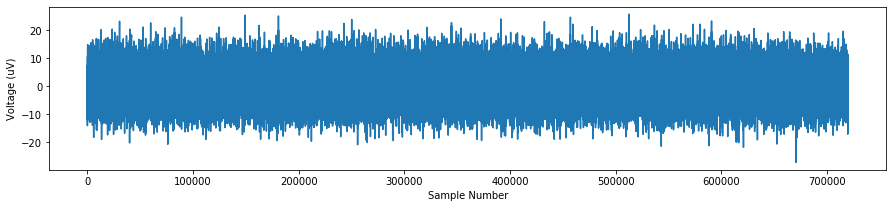

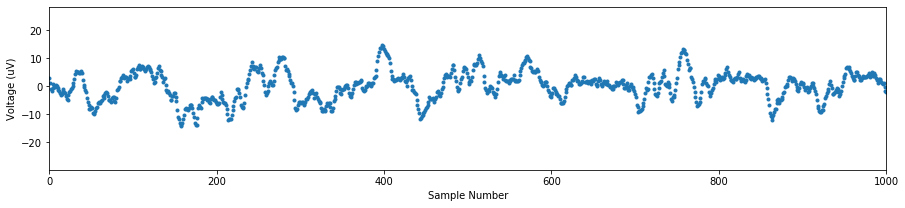

In [2]:
# scipy loads .mat file into a dictionary
# the details are not crucial, we just have to unpack them into python variables
EEG_data = io.loadmat('data/EEG_exp.mat', squeeze_me = True)

# print all the variables that exist in the dictionary
print(EEG_data.keys())

# this contains the EEG data
EEG = EEG_data['EEG']
# this contains the sampling rate, in Hz (or samples/second)
fs = EEG_data['fs']

# let's plot the signal
plt.figure(figsize=(15,3))
plt.plot(EEG)
# ALWAYS label your plot axes in this course (and ever)
plt.xlabel('Sample Number')
plt.ylabel('Voltage (uV)')

# now let's zoom in to see more detail
plt.figure(figsize=(15,3))
plt.plot(EEG, '.') # '.' means plot the data points as individual dots without linking them
plt.xlim([0,1000]) # this limits the x-axis shown
plt.xlabel('Sample Number')
plt.ylabel('Voltage (uV)')

# [3] Q2: Digitization
As you can see above, the signal we loaded is already a digitally sampled time series (a little over 70,000 samples), represented by discrete points in the second plot. To study the effect of quantization, let's simulate what would happen if we further quantized the signal, with a (prehistoric) 4-bit ADC.

[1] How many possible values can a 4-bit ADC represent? Remember, this means that the ADC has 4 binary 'bits' that it can use, thus giving you a total of how many levels? Compute this number in code and store that value in the variable `num_levels` below.

[1] Let's say our ADC has a total range between -32uV to 32uV. What is the voltage resolution of our ADC then? In other words, what is the finest voltage difference our ADC can distinguish between two samples? Compute this number in code and store that value in the variable `delta_v` below.

[1] Run the next two cells, they should produce a graph where the orange trace looks very quantized (kind of square). This is not good, because then we cannot distinguish small fluctuations in our signals, which, as we will see later in the course, are very important. **Re-run** the next two cells, but experiment with different values for `num_bits`. Just based on visual inspection of the plot, what is the minimum number of bits that you would want your ADC to have in this case, assuming the blue trace is a faithful representation of your signal? There's no one right answer, but justify your response.

ANSWER: You would want the minimum num_bits to be 6. This would change your number of levels to be 64 and your resolution to be 1. After running the two cells, the orange line almost aligned with the blue line, showing that it is a pretty accurate representation of the fluctuations.

In [3]:
num_bits = 6
min_v, max_v = -32,32

num_levels = 64 
delta_v = 1

Text(0, 0.5, 'Voltage (uV)')

/Users/daniellew/anaconda3/lib/python3.7/site-packages/IPython/core/events.py:88: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)
/Users/daniellew/anaconda3/lib/python3.7/site-packages/IPython/core/pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


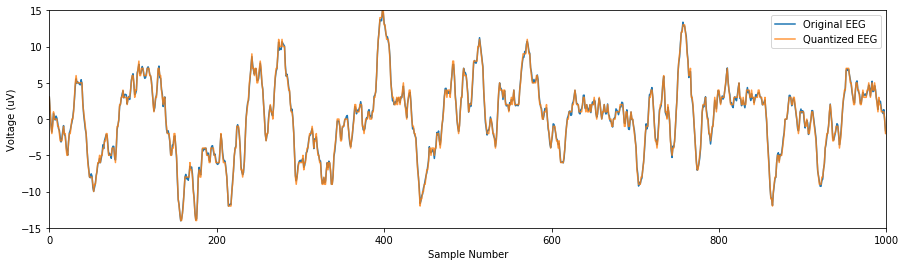

In [4]:
# create the quantization vector, these are the new possible values that your signal can take
ADC_levels = np.arange(min_v,max_v,delta_v)+delta_v/2

# quantize the EEG signal with our crappy ADC with the function np.digitize
# note that we have to scale the redigitized signal to its original units
EEG_quant = np.digitize(EEG,bins=ADC_levels)*delta_v+min_v

plt.figure(figsize=(15,4))
plt.plot(EEG, label='Original EEG')
plt.plot(EEG_quant, label='Quantized EEG', alpha=0.8)
plt.xlim([0,1000]); plt.ylim([-15, 15]);
plt.legend()
plt.xlabel('Sample Number')
plt.ylabel('Voltage (uV)')

---
# Sample Number vs. Time
Notice that in all the plots above, the x-axis is "sample number", which simply correponds to the position each value is in the array `EEG`. We want to create a corresponding time vector, which marks at what clock time each value is sampled at. 

Sometimes your data will include a time vector. But for the sake of this exercise, you are asked to create the time vector based on the information/variables you have.

# [6] Q3: Sampling in Time
[1] Given the sampling rate, what is the sampling **period**? In other words, how much time elapses between each consecutive sample? Compute this number as a function of `fs` and store it in the variable `dt` below.

[1] How long in total is this signal, in absolute time? Compute and store this in the variable `T_exp` below.

[1] Construct the corresponding time vector for the EEG data, assuming that the first sample came at t=0 and evenly spaced samples at `dt`. Store that in the variable `t_EEG` below. Hint: check out the function `np.arange()`.

[2] Re-plot the signal as a line chart, but with the x-axis as time (using the time vector you created above), and zoom into the first 1 second of the data. **Take note to label your plots carefully, with units!**

[1] To simulate **downsampling** in time, plot every **10th** value of the EEG data by indexing the array (check Google/StackExchange for how to do this). Remember, this applies both to the time vector and your EEG data. **Make sure to label your data and display the legend as Q2 above.**

[BONUS: 1] Sometimes it's useful to downsample your signal in time to conserve memory. As we did above, by taking every 10th value in our data, we essentially reduce the data size 10-fold. However, this is **NOT** the entirely right way to downsample your data. What issue do we introduce when we simply do that? (Hint: the answer can be as short as one word, and Google is your friend here.)

ANSWER: Noise

Text(0, 0.5, 'voltage (uV)')

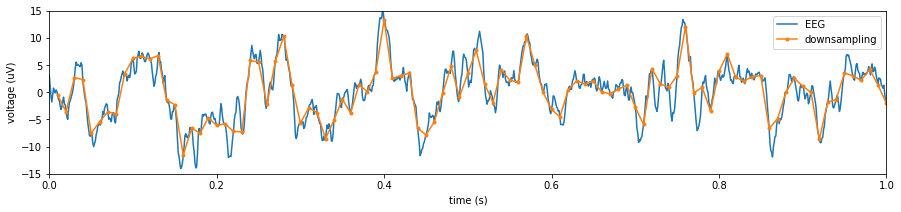

In [6]:
dt = 1/fs
T_exp = len(EEG)*dt 
t_EEG = np.arange(0, T_exp, dt)

# Plotting the signal and its downsampled version
plt.figure(figsize=(15,3))

plt.plot(t_EEG, EEG, label='EEG')
plt.plot(t_EEG[10::10], EEG[10::10], '.-', label="downsampling")
plt.xlim([0,1]); plt.ylim([-15, 15]);
plt.legend()
plt.xlabel('time (s)')
plt.ylabel('voltage (uV)')

# Event-Related Analysis
The above data actually comes from an event-style EEG experiment. The participant is shown visual stimuli at regular intervals, aimed to trigger a reliable brain response for each type of stimuli (cat vs. dog pics, for example). This is a very common type of study design in neuroscience (and psychology). 

In this case, we will need to know when a stimulus was presented, and what type of stimulus it was. This information is stored in the variable `trial_info`, where the **first column has the stimulus onset time (in seconds), and the second column has the type of stimulus shown (1,2, or 3).** These are often extra streams of data sent through the "trigger channel" by the stimulus-presenting computer directly to the recording equipment, in order to synchronize with the EEG data.

In [7]:
trial_info = EEG_data['trial_info']

# print the first 10 events
print(trial_info[:10,:])

[[ 1.     3.   ]
 [ 3.375  3.   ]
 [ 5.87   1.   ]
 [ 8.183  2.   ]
 [10.419  1.   ]
 [12.588  1.   ]
 [14.87   2.   ]
 [17.086  2.   ]
 [19.164  3.   ]
 [21.237  2.   ]]


---
# Process for Analyzing Event-Related Data
These types of experiments follow a pretty standard analysis process. 
1. Import and pre-process your data (already done; we'll skip the pre-processing for now)
2. Given the stimulus presentation timestamps (first column of `trial_info` above), find the corresponding indices in your EEG data by matching to the `t_EEG` time vector.
3. Cut out an **epoch** (window of data) around the stimulus presentation time, which usually includes:
    - pre-stimulus baseline (~0.5 seconds before stimulus presentation)
    - stimulus presentation (t = 0)
    - stimulus-driven response (or event-related response, 0-1 second after stimulus presentation)
4. Baseline subtraction: subtract each epoch by its mean pre-stimulus value to account for any slow drifts over time.
5. Group epochs based on stimulus type, and average epochs of the same type.
6. Plot the average response (s).

# [4] Q4: Step 2 - Find Matching Timestamps in EEG Data
Given the event times in `trial_info`, which we will assume to be the stimulus onset time for this experiment, we have to find the corresponding timestamp in the EEG data. Note that the timestamps may not always match exactly, as they could have different sampling rates. In those cases, you will have to settle for finding the **closest** timestamps. Currently, however, life was made easy for us by virtue of the fact that the EEG data (and timestamps) and the stimulus event timestamps are synchronously sampled at 1000Hz.

In this case, we can directly convert the event timestamp into an integer index, since we know the sampling frequency and starting time. 

[1] If the EEG timestamp starts at `t=0`, which is indexed by `i=0`, and is sampled at `fs=1000`, at which index will the EEG timestamp be equal to **3.050 seconds**? Compute and store this in the variable `trial_index` below. Note that to index an array, the number has to be an integer, which I've converted for you. (You will notice that the value is *a LITTLE* off. That's a precision issue and We can ignore that for now.)

[3] Following this logic, write a function that will find the corresponding index in the EEG data/timestamp for every event timestamp. Return that as an array of integers (`my_arr.astype(int)` will convert an array to all integers). You may use a for loop, list comprehension, or a simple (one-line) array calculation for this. Confirm that the timestamps match what you expect by printing the first 10 events (I've done this for you).

In [15]:
trial_index = (1000 * 3.050)
print(t_EEG[np.array(trial_index).astype(int)]) # access the value at the corresponding index

3.0500000000000003


In [45]:
def compute_EEG_indices(event_timestamps, fs):
    timestampsList = []
    for n in event_timestamps:
        timestampsList.append(n[0] * fs)
    return np.array(timestampsList).astype(int)

# call your function to compute the corresponding indices
EEG_indices = compute_EEG_indices(trial_info, fs)

# print your solution and the actual event times to compare, they should be identical
print(t_EEG[EEG_indices[:10]])
print(trial_info[:10,0])


[ 1.     3.375  5.87   8.183 10.419 12.588 14.87  17.086 19.164 21.237]
[ 1.     3.375  5.87   8.183 10.419 12.588 14.87  17.086 19.164 21.237]


# [6] Q5: Step 3 - Grabbing Epochs
Now that we have the corresponding indices in the EEG data, we know exactly where the **onset** of each stimulus is. The next thing we have to do is to grab a chunk of data surrounding the onset time, which we define to be `t=0` for every trial. That means you will want to grab a little bit of data before and after that time. 

[3] Write a function that will, given an array of `data`, the sampling rate `fs`, and an `index`, grab a window of data surrounding that index, defined by `len_pre` and `len_post` in **seconds**. Note that `len_pre` should be negative to reflect that it's before the stimulus onset time. I've started this function for you below. Again, there are multiple ways to accomplish this, but the simplest solution can accomplish this in a single line.

[1] Use this function to grab an epoch for the **10th trial** (remember that's stored in `EEG_indices` already), with a pre-stimulus window of 0.5 seconds and a post-stimulus window of 1 second.

[1] Create a time vector `t_epoch` that corresponds to the timestamps for that epoch, relative to the stimulus onset time as zero. In other words, this time vector should start at `len_pre` and end at `len_post`, and has the same sampling frequency.

[1] Plot the epoch of data you grabbed. Note that the x-axis should be time. **Label your axes!**

In [ ]:
def grab_epoch(data, index, fs, len_pre, len_post):
    # _FILL_IN_YOUR_CODE_HERE 
    return 


# _FILL_IN_YOUR_CODE_HERE 
len_pre = -0.5 #second
len_post = 1 #second
epoch = grab_epoch(_FILL_IN_YOUR_CODE_HERE)
print(epoch[:5])

t_epoch = # _FILL_IN_YOUR_CODE_HERE 

# plotting
plt.figure(figsize=(6,4))
# _FILL_IN_YOUR_CODE_HERE

# [4] Q6: Step 4 - Grab All & Baseline Correct (Bonus)
[2] If you grab an epoch for every trial and store that in a 2D numpy matrix, what should the dimensions of that matrix be, i.e., how many rows and how many columns? What do those numbers correspond to? Hint: you should organize your data such that there are more columns than rows in this particular case.

ANSWER:

[2] Write a function that grabs **all** epochs (every trial) and store that in a 2D numpy matrix. There are a few ways to do this, but they will likely all use `grab_epoch()` somehow. Confirm that it has the same shape that you expect from above. Hint: you can append your epochs indefinitely to a python list using `list.append()`, and use `np.array()` to automatically convert that into a 2D matrix.

[BONUS: 2] Baseline all your epochs by subtracting the pre-stimulus epoch mean (-0.5 to 0 seconds) of each epoch from itself.

In [ ]:
def get_all_epochs(data, indices, fs, len_pre, len_post):
    # _FILL_IN_YOUR_CODE_HERE 
    # get all epochs

    # baselining (if you want, it can also be a separate function)

    return all_epochs

In [ ]:
epoched_EEG = get_all_epochs(EEG, EEG_indices, fs, len_pre, len_post)
print(epoched_EEG.shape)

# plot all the epochs and average
plt.plot(t_epoch, epoched_EEG.T, '-k', alpha=0.01)
plt.plot(t_epoch, np.mean(epoched_EEG,axis=0), label='Average Response')
plt.xlabel('Time (s)')
plt.ylabel('Voltage (uV)')
plt.legend()

# [6] Q7: Step 5 & 6 - Group Based on Trial Type
In the plot above, I simply averaged over all the epochs to produce the average response (blue). However, as you will recall, there are several different types of trials (second column in `trial_info`). We should group epochs of the same trial type, and average over those. 

[5] You have full flexibility for this part, with the only requirement being to produce a plot with 3 average responses corresponding to the 3 different trial types. Remember to label your plot axes and include a legend for which trace corresponds to which stimulus type. You will be evaluated on 3 things: whether you have successfully separated the epochs into their respective groupings, how well your code is commented to explain what you're doing, and whether you plot is correct and labeled. 

Since I have not given you a template for making a function, it may be useful to plan out what you want to do beforehand by writing pseudo code (i.e., plain English). Decide what strategy you will take (loops vs. list comprehension vs. others), and whether you want to separate the averaging and the plotting. You already know all the concepts required to tackle this problem (indexing, averaging, plotting), the challenge is putting them together. 

[1] Briefly describe your results, e.g., what's similar and what's different between the conditions? Which stimulus produced the largest response.

ANSWER:

---
Your plot should look something like:

![example_erp](img/example_erp.jpg)

In [ ]:
# _FILL_IN_YOUR_CODE_HERE

# That's All!
There! You just performed your first neural data analysis. This type of stimulus-locked experiment design and analysis is very common in neuroscience, especially human and animal electrophysiology. Here at UCSD, Profs. Marta Kutas, Seana Coulson, and Sarah Creel all deploy these types of human EEG experiments to probe various aspects of the neural correlates of cognition. You will also see how it's applied in the paper we will discuss this week, and other commercial applications.

# End Survery
Please take a few minutes to fill out the following as it will help us to improve the following assignments & lectures.

# Content:
What was one thing you learned from this lab & associated lectures?

ANSWER: 

---
What was one thing that you still found confusing after the lab, and need clarification?

ANSWER:

# Style:
What was one thing you enjoyed about the formatting of this assignment (e.g., clarity, structure, guidance, etc.)?

Answer:

---
What was one thing that you thought could use improvements on?

Answer:


# Thank you!